## Tiny NeDF

In [11]:
# Import all the good stuff
import cv2
import numpy as np
import torch
import matplotlib.pyplot as plt

### Utilitary functions

In [12]:
def meshgrid_xy(tensor1: torch.Tensor, tensor2: torch.Tensor) -> (torch.Tensor, torch.Tensor):
    """Mimick np.meshgrid(..., indexing="xy") in pytorch. torch.meshgrid only allows "ij" indexing.
    (If you're unsure what this means, safely skip trying to understand this, and run a tiny example!)

    Args:
      tensor1 (torch.Tensor): Tensor whose elements define the first dimension of the returned meshgrid.
      tensor2 (torch.Tensor): Tensor whose elements define the second dimension of the returned meshgrid.
    """
    # TESTED
    ii, jj = torch.meshgrid(tensor1, tensor2)
    return ii.transpose(-1, -2), jj.transpose(-1, -2)


def cumprod_exclusive(tensor: torch.Tensor) -> torch.Tensor:
  r"""Mimick functionality of tf.math.cumprod(..., exclusive=True), as it isn't available in PyTorch.

  Args:
    tensor (torch.Tensor): Tensor whose cumprod (cumulative product, see `torch.cumprod`) along dim=-1
      is to be computed.

  Returns:
    cumprod (torch.Tensor): cumprod of Tensor along dim=-1, mimiciking the functionality of
      tf.math.cumprod(..., exclusive=True) (see `tf.math.cumprod` for details).
  """
  # TESTED
  # Only works for the last dimension (dim=-1)
  dim = -1
  # Compute regular cumprod first (this is equivalent to `tf.math.cumprod(..., exclusive=False)`).
  cumprod = torch.cumprod(tensor, dim)
  # "Roll" the elements along dimension 'dim' by 1 element.
  cumprod = torch.roll(cumprod, 1, dim)
  # Replace the first element by "1" as this is what tf.cumprod(..., exclusive=True) does.
  cumprod[..., 0] = 1.

  return cumprod

In [13]:
def get_ray_bundle(height: int, width: int, focal_length: float, tform_cam2world: torch.Tensor):
  r"""Compute the bundle of rays passing through all pixels of an image (one ray per pixel).

  Args:
    height (int): Height of an image (number of pixels).
    width (int): Width of an image (number of pixels).
    focal_length (float or torch.Tensor): Focal length (number of pixels, i.e., calibrated intrinsics).
    tform_cam2world (torch.Tensor): A 6-DoF rigid-body transform (shape: :math:`(4, 4)`) that
      transforms a 3D point from the camera frame to the "world" frame for the current example.

  Returns:
    ray_origins (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the centers of
      each ray. `ray_origins[i][j]` denotes the origin of the ray passing through pixel at
      row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
    ray_directions (torch.Tensor): A tensor of shape :math:`(width, height, 3)` denoting the
      direction of each ray (a unit vector). `ray_directions[i][j]` denotes the direction of the ray
      passing through the pixel at row index `j` and column index `i`.
      (TODO: double check if explanation of row and col indices convention is right).
  """
  # TESTED
  ii, jj = meshgrid_xy(
      torch.arange(width).to(tform_cam2world),
      torch.arange(height).to(tform_cam2world)
  )
  directions = torch.stack([(ii - width * .5) / focal_length,
                            -(jj - height * .5) / focal_length,
                            -torch.ones_like(ii)
                           ], dim=-1)
  ray_directions = torch.sum(directions[..., None, :] * tform_cam2world[:3, :3], dim=-1)
  ray_origins = tform_cam2world[:3, -1].expand(ray_directions.shape)
  return ray_origins, ray_directions

### Network architecture

In [14]:
class VeryTinyNeDFModel(torch.nn.Module):
    r"""Define a "very tiny" NeDF model comprising three fully connected layers."""
    def __init__(self, filter_size=128, far_thresh=1000.0, L=10):
        self.L = L
        # self.input_dim = 3 + 2 * L * 3 # Due to positional encoding
        self.input_dim = 3 # Since we don't use it, just x,y,z
        super(VeryTinyNeDFModel, self).__init__()
        # Input layer (default: 3 + 2 * L * 3 -> 128 if positional encoding is enabled, 3 -> 128 otherwise)
        self.layer1 = torch.nn.Linear(self.input_dim, filter_size)
        # Layer 2 (default: 128 -> 128)
        self.layer2 = torch.nn.Linear(filter_size, filter_size)
        # Layer 3 (default: 128 -> 1) for predicting distance
        self.layer3 = torch.nn.Linear(filter_size, 1)
        # Short hand for torch.nn.functional.relu
        self.relu = torch.nn.functional.relu
        self.far_thresh = far_thresh

    # Not convincing currently
    def positional_encoding(self, x):
        encoded = [x]
        for i in range(self.L):
            encoded.append(torch.sin(2**i * x))
            encoded.append(torch.cos(2**i * x))
        return torch.cat(encoded, dim=-1)

    def forward(self, x):
        # x = self.positional_encoding(x)
        x = self.relu(self.layer1(x))
        x = self.relu(self.layer2(x))
        x = self.layer3(x) # Output is raw distance
        return torch.clamp(x, min=0.0, max=self.far_thresh) # Clamp output to prevent crazy / negative distances


### GPU vs CPU ?

In [15]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


### Load input images, poses, intrinsics, etc.

In [16]:
# Load input images, poses, and intrinsics
data = np.load("data/tiny_nedf/depth_map_test.npz")

# Camera extrinsics (poses)
testpose = data["pose"]
testpose = torch.from_numpy(testpose).to(device)

# Focal length (intrinsics)
focal_length = data["focal"]
focal_length = torch.from_numpy(focal_length).to(device)

testimg = data["depth_map"]
# testimg = np.resize(testimg, (6, 6))
testimg = torch.from_numpy(testimg).to(device)

print(testimg.shape)
# Height and width depth map
height, width = testimg.shape[:2]

# Near and far clipping thresholds for depth values.
near_thresh = 0.01
far_thresh = 500.0

torch.Size([100, 100])


### Display the image used for testing

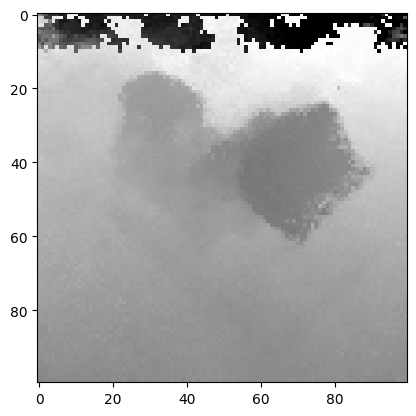

In [17]:
plt.imshow(testimg.detach().cpu().numpy(), cmap='gray')
plt.show()

### Train !

This method renders a depth map using the model's predictions to dynamically adjust step size during ray marching.

In [18]:
def render_depth_sphere_tracing(
    distance_field_model: torch.nn.Module,
    ray_origins: torch.Tensor,
    ray_directions: torch.Tensor,
    depth_map: torch.Tensor,
    near_thresh: float,
    max_iterations: int = 50
) -> torch.Tensor:

    # Create a tensor to track active rays
    active_mask = torch.ones_like(depth_map, dtype=torch.bool)

    # Predicted depth map
    dstTravelled = torch.full_like(depth_map, 0, requires_grad=True)
    steps = torch.zeros_like(active_mask, dtype=torch.float32)
    
    all_query_points = []
    all_predicted_distances = []

    for i in range(max_iterations):
        # Stop if no active rays remain
        if not torch.any(active_mask):
            break
        
        # Compute the query points
        query_points = ray_origins + ray_directions * dstTravelled[..., None]
        query_points.requires_grad_()
        
        # Predict distances using the model
        predicted_distances = distance_field_model(query_points).squeeze(-1)

        # Increment the steps for active rays
        steps = torch.where(active_mask, steps + 1, steps)

        # Mask for rays that are within the surface threshold or exceeding far_thresh
        hit_mask = ((predicted_distances < near_thresh) | (dstTravelled >= depth_map)) & active_mask

        # Store active query points and predictions
        all_query_points.append(query_points[~hit_mask])
        all_predicted_distances.append(predicted_distances[~hit_mask])

        # Update active mask to deactivate rays that hit
        active_mask = active_mask & ~hit_mask
        
        # Update the depth map only for rays that have hit
        dstTravelled = torch.where(active_mask, dstTravelled + predicted_distances, dstTravelled)

    # Concatenate query points and distances
    all_query_points = torch.cat(all_query_points, dim=0)
    all_predicted_distances = torch.cat(all_predicted_distances, dim=0)

    return dstTravelled, steps, all_query_points, all_predicted_distances

In [19]:
def compute_gradients(model, query_points, eps=1e-4, sample_ratio=0.1):
    """
    Computes numerical gradients of SDF using finite differences.

    Args:
    - model: The implicit function.
    - query_points: Tensor of shape [N, 3], query points.
    - eps: Small step for finite differences.
    - sample_ratio: Fraction of points to sample for gradient computation.

    Returns:
    - gradients: Tensor of shape [sampled_N, 3], computed gradients.
    """
    N = query_points.shape[0]
    device = query_points.device

    # Randomly sample query points
    nb_samples = min(int(N * sample_ratio), 5000)
    sampled_indices = torch.randperm(N, device=device)[:nb_samples]
    sampled_points = query_points[sampled_indices]

    # Allocate memory for gradients
    gradients = torch.zeros_like(sampled_points, device=device)

    for i in range(3):  # Compute gradient w.r.t x, y, z
        offset = torch.zeros_like(sampled_points, device=device)
        offset[:, i] = eps

        forward_points = sampled_points + offset
        backward_points = sampled_points - offset

        forward_sdf = model(forward_points).squeeze(-1)
        backward_sdf = model(backward_points).squeeze(-1)

        # Central finite difference
        gradients[:, i] = (forward_sdf - backward_sdf) / (2 * eps)

    return gradients

def compute_eikonal_loss(gradients):
    """
    Computes the Eikonal loss using the computed gradients.

    Args:
    - gradients (torch.Tensor): Tensor of shape [N, 3] containing the gradients of SDF predictions.

    Returns:
    - loss (torch.Tensor): Computed Eikonal loss.
    """
    # ||grad|| should be close to 1, compute the deviation from 1
    loss = torch.mean(torch.abs(torch.norm(gradients, dim=-1) - 1))
    return loss

And now the training loop.

In [20]:
# Training parameters
L = 5
lr = 1e-4
num_iters = 2500

# Misc parameters
display_every = 5

# Model
model = VeryTinyNeDFModel(L=L)
model.to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# Seed RNG
seed = 9458
torch.manual_seed(seed)
np.random.seed(seed)

# Setup training
target_depth = testimg.float().to(device)
target_tform_cam2world = testpose
ray_origins, ray_directions = get_ray_bundle(height, width, focal_length, target_tform_cam2world)

# Save depth maps for video
depth_maps = []

eikonal_penalty_weight = 5  # Weight for eikonal loss

step_penalty_weight = 0  # Adjust weight to balance depth loss and step penalty
step_penalty_alpha = 0.05  # Exponential growth factor for step penalty

for i in range(num_iters):
    # Use NeDF sphere tracing to compute the depth map and step count
    depth_predicted, steps, query_points, query_results = render_depth_sphere_tracing(model, ray_origins, ray_directions, target_depth, near_thresh)

    gradients = compute_gradients(model, query_points)
    eikonal_loss = compute_eikonal_loss(gradients)

    # Compute the mean-squared error loss between predicted and true depth map
    depth_loss = torch.nn.functional.mse_loss(depth_predicted, target_depth)

    # Exponential penalty for step count to prioritize reducing steps (not working)
    # step_penalty = torch.mean(torch.exp(step_penalty_alpha * steps))
    
    # Use eikonal loss instead, very effective
    eikonal_penalty = eikonal_penalty_weight * eikonal_loss

    # Combine the depth loss and step penalty
    loss = depth_loss + eikonal_penalty

    # Backpropagation and optimization
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Display progress
    if i % display_every == 0:
        print(f"Step {i}:")
        print(f"Loss: {loss}")
        print(f"Average steps: {steps.mean().item()}")
        print(f"Eikonal loss: {eikonal_loss}")
        
        # Convert depth map to image (normalize for visualization)
        depth_img = depth_predicted.detach().cpu().numpy()
        depth_img_normalized = (depth_img - depth_img.min()) / (depth_img.max() - depth_img.min()) * 255.0
        depth_maps.append(depth_img_normalized.astype(np.uint8))

        # Display the current depth map
        # plt.imshow(depth_img_normalized, cmap='inferno')
        # plt.title(f"Iteration {i} - Depth Map")
        # plt.colorbar()
        # plt.show()

print('Training done !')

# Save the video using OpenCV
output_file = "depth_map_training.mp4"
height, width = depth_maps[0].shape
video_writer = cv2.VideoWriter(
    output_file, cv2.VideoWriter_fourcc(*'mp4v'), 5, (width, height), isColor=True
)

# Write each depth map to the video
for depth_map in depth_maps:
    # Ensure grayscale map is expanded to (H, W, 3) to represent RGB channels
    frame = np.stack([depth_map]*3, axis=-1)  # Duplicate grayscale into R, G, B
    video_writer.write(frame)

video_writer.release()
print(f"Video saved successfully as {output_file}")

Step 0:
Loss: 6.885506629943848
Average steps: 45.96039962768555
Eikonal loss: 0.9384042620658875
Step 5:
Loss: 5.683990001678467
Average steps: 38.471797943115234
Eikonal loss: 0.9152386784553528
Step 10:
Loss: 4.960142612457275
Average steps: 32.16339874267578
Eikonal loss: 0.8988671898841858
Step 15:
Loss: 4.641495227813721
Average steps: 28.435998916625977
Eikonal loss: 0.8882904052734375
Step 20:
Loss: 4.4679856300354
Average steps: 26.381500244140625
Eikonal loss: 0.8835778832435608
Step 25:
Loss: 4.39393424987793
Average steps: 24.38519859313965
Eikonal loss: 0.8764650225639343
Step 30:
Loss: 4.34262228012085
Average steps: 22.64219856262207
Eikonal loss: 0.8659908175468445
Step 35:
Loss: 4.29560661315918
Average steps: 21.769298553466797
Eikonal loss: 0.855269193649292
Step 40:
Loss: 4.25394868850708
Average steps: 21.557899475097656
Eikonal loss: 0.8447630405426025
Step 45:
Loss: 4.213818550109863
Average steps: 21.46769905090332
Eikonal loss: 0.8338454961776733
Step 50:
Loss: